# Question 2
导入必要的库

In [1]:
from random_forest_Q2 import *
from scipy.optimize import minimize
from itertools import product, combinations
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import pandas as pd

## 预测人数
### 随机森林模型主流程

交叉验证最佳分数: 0.5369047619047619
最佳参数: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
模型评估指标：
准确率: 0.8000
精确率: 0.8542
召回率: 0.8333
F1分数: 0.8310
AUC值: 0.9259


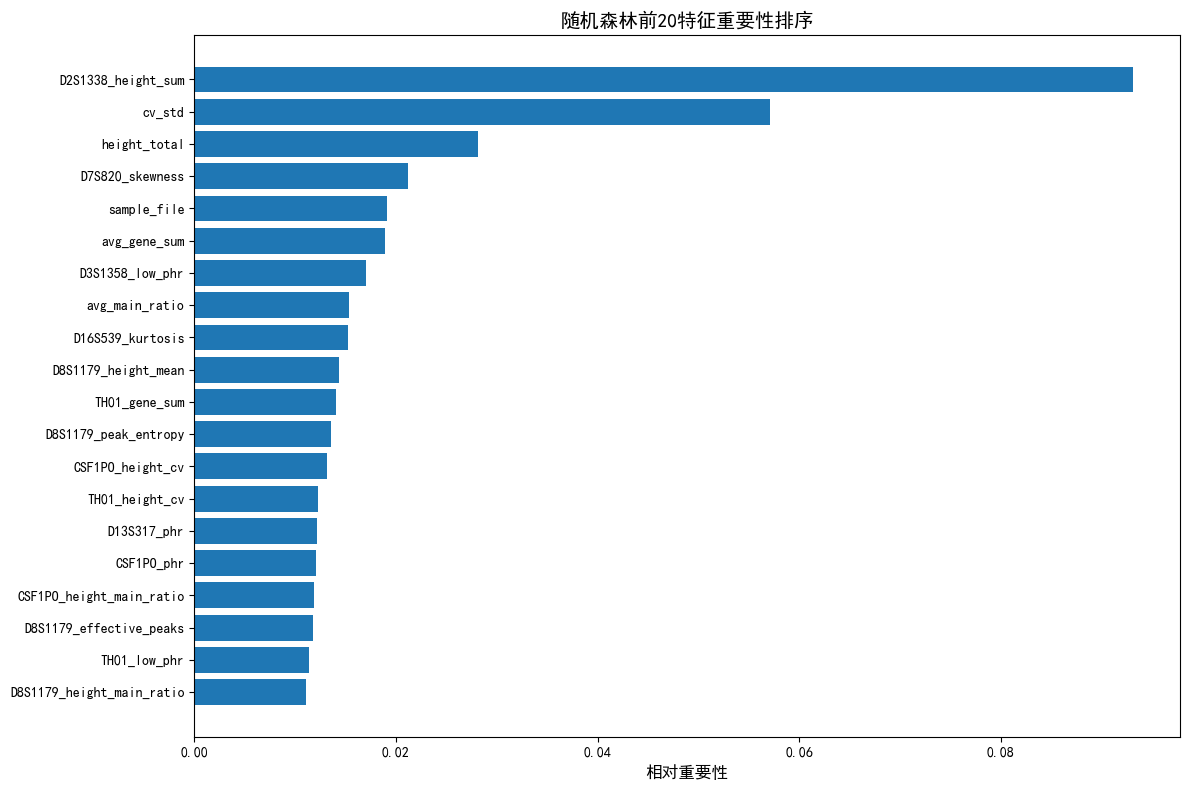

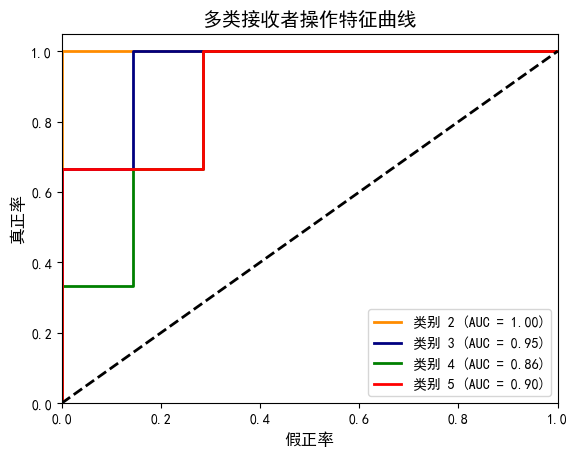

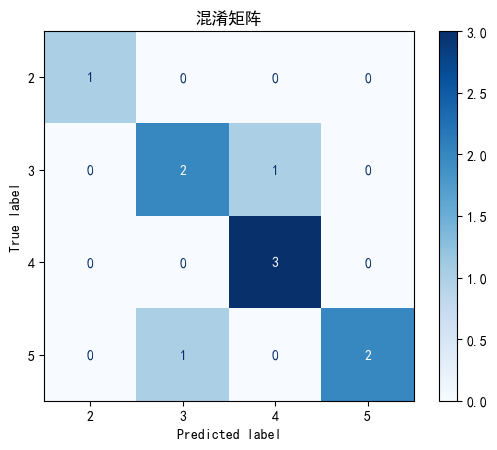

In [2]:
# 1. 加载原始数据
original_data = pd.read_excel('D题附件：法医物证多人身份鉴定问题数据集/附件2：不同混合比例的STR图谱数据_processed.xlsx')

# 2. 加载并预处理模型数据
df = load_and_preprocess(data_path="data/enhanced_processed_Q2_data.xlsx")
X = df.drop(['people', 'gene_from', 'proportion'], axis=1)
y = df['people']

# 划分训练集/测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
test_sample_files = X_test['sample_file']

# 3. 模型训练
rf_model, feature_selector = train_random_forest(
    X_train.drop('sample_file', axis=1),
    y_train
)

# 4. 模型预测
X_test_selected = feature_selector.transform(X_test.drop('sample_file', axis=1))
y_pred = rf_model.predict(X_test_selected)
y_proba = rf_model.predict_proba(X_test_selected)

# 5. 模型评估
print("=" * 40)
print("模型评估指标：")
print(f"准确率: {accuracy_score(y_test, y_pred):.4f}")
print(f"精确率: {precision_score(y_test, y_pred, average='macro'):.4f}")
print(f"召回率: {recall_score(y_test, y_pred, average='macro'):.4f}")
print(f"F1分数: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"AUC值: {roc_auc_score(y_test, y_proba, multi_class='ovo'):.4f}")

# 6. 可视化输出
# 特征重要性图
plot_feature_importance(rf_model, X.columns.tolist(), "images/Q2/feature_importance.png")

# ROC曲线
plot_roc_curve(y_test, y_proba, "images/Q2/roc_curve.png")

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("混淆矩阵")
plt.savefig("images/Q2/confusion_matrix.png", dpi=300)
plt.show()
plt.close()

### 提取测试集数据结果

In [3]:
#合并到原始数据
predictions = pd.DataFrame({
    'Sample File': test_sample_files,
    'predicted_people': y_pred
})
data_test = original_data[original_data['Sample File'].isin(test_sample_files)]
data_test = data_test.merge(predictions, on='Sample File', how='left')

# 将predicted_people列移动到第5列位置
cols = data_test.columns.tolist()
cols.remove('predicted_people')
cols.insert(4, 'predicted_people')  # 插入到第5列位置(索引4)
data_test = data_test[cols]

# 验证每个样本的预测值唯一性
assert data_test.groupby('Sample File')['predicted_people'].nunique().max() == 1

# 5. 输出结果
# data_test.to_excel('data/Q2_temp.xlsx', index=False)

## 预测比例
### 生成贡献矩阵A_i，归一化样本矩阵C

In [4]:
# 基因座数据配置
GENE_LOCI = {
    'D8S1179': [10, 11, 12, 13, 14, 15, 16],
    'D21S11': [24.3, 27, 28, 29, 30, 31, 31.2, 32, 32.2, 33, 33.2, 35, 36],
    'D7S820': [7, 8, 9, 10, 11, 12, 13],
    'CSF1PO': [7, 8, 9, 10, 11, 12, 13],
    'D3S1358': [14, 15, 16, 17, 18],
    'TH01': [5, 6, 7, 8, 9, 9.3],
    'D13S317': [8, 9, 10, 11, 12, 13, 14],
    'D16S539': [8, 9, 10, 11, 12, 13, 14],
    'D2S1338': [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
    'D19S433': [10, 10.2, 11, 12, 12.2, 13, 13.2, 14, 14.2, 15, 15.2, 16, 16.2],
    'vWA': [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'TPOX': [6, 7, 8, 9, 10, 11, 12],
    'D18S51': [10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23],
    'AMEL': ['X', 'Y'],
    'D5S818': [7, 8, 9, 10, 11, 12, 13, 14],
    'FGA': [19, 20, 21, 21.2, 22, 22.2, 23, 24, 25, 26, 27, 28]
}

In [5]:
# 生成样本矩阵C
def generate_C_matrix(sample_name, data_test, GENE_LOCI):
    """
    返回NumPy矩阵的最终版本

    参数:
    sample_name (str): 样本名称（需完全匹配）
    data_test (pd.DataFrame): 包含所有样本数据的DataFrame
    GENE_LOCI (dict): 各基因座的标准等位基因定义

    返回:
    np.ndarray: 16xN的归一化峰高比例矩阵，N为各基因座最大等位基因数
    """
    # 输入验证
    if not isinstance(data_test, pd.DataFrame):
        raise ValueError("输入数据必须为Pandas DataFrame")
    if sample_name not in data_test['Sample File'].values:
        raise ValueError(f"样本 {sample_name} 不存在")

    # 获取基因座顺序列表
    loci_order = list(GENE_LOCI.keys())

    # 预计算最大等位基因数量
    max_alleles = max(len(v) for v in GENE_LOCI.values())

    # 初始化矩阵容器
    matrix_data = np.zeros((len(GENE_LOCI), max_alleles), dtype=np.float32)

    # 处理每个基因座
    for locus_idx, (locus_name, alleles) in enumerate(GENE_LOCI.items()):
        # 转换标准等位基因格式
        if locus_name == 'AMEL':
            std_alleles = [str(a).upper() for a in alleles]  # 性别基因大写处理
        else:
            std_alleles = [f"{float(a):g}" for a in alleles]  # 数值型统一格式

        # 获取当前基因座数据
        sample_mask = (
            (data_test['Sample File'] == sample_name) &
            (data_test['Marker'].str.upper() == locus_name.upper())
        )
        locus_data = data_test[sample_mask].copy()

        if not locus_data.empty:
            allele_counts = defaultdict(float)

            # 遍历所有Allele列
            for col in [c for c in locus_data.columns if c.startswith('Allele')]:
                col_num = col.split()[-1]
                height_col = f'Height {col_num}'

                # 提取等位基因和峰高
                allele = str(locus_data[col].iloc[0]).strip()
                height = locus_data[height_col].iloc[0]

                # 过滤无效数据
                if pd.isna(allele) or pd.isna(height) or 'OL' in allele:
                    continue

                # 格式处理
                try:
                    processed_allele = (
                        allele.upper() if locus_name == 'AMEL'
                        else f"{float(allele):g}"
                    )
                except ValueError:
                    continue

                # 累加峰高值
                allele_counts[processed_allele] += float(height)

            # 应用动态阈值筛选
            valid_heights = [h for h in allele_counts.values() if h > 0]
            if valid_heights:
                max_height = max(valid_heights)
                total_height = sum(valid_heights)
                threshold = max(0.1 * max_height, 0.01 * total_height)
                filtered = {k:v for k,v in allele_counts.items() if v >= threshold}

                # 归一化处理
                valid_total = sum(filtered.get(a, 0) for a in std_alleles)
                if valid_total > 0:
                    for idx, allele in enumerate(std_alleles):
                        if idx >= max_alleles:  # 防止索引越界
                            break
                        matrix_data[locus_idx, idx] = filtered.get(allele, 0.0) / valid_total

    # 验证矩阵维度
    assert matrix_data.shape == (16, max_alleles), f"矩阵维度异常，应为(16, {max_alleles})"

    return matrix_data

In [6]:
#生成矩阵A
class LegalMatrixGenerator:
    """合法贡献矩阵生成器"""
    def __init__(self, gene_loci):
        self.gene_loci = gene_loci
        self.locus_combinations = self._precompute_combinations()

    def _precompute_combinations(self):
        """预计算各基因座合法组合"""
        combinations_dict = {}
        for locus, alleles in self.gene_loci.items():
            n = len(alleles)
            combs = []
            # 纯合子
            for i in range(n):
                vec = np.zeros(n, dtype=np.int8)
                vec[i] = 2
                combs.append(vec)
            # 杂合子
            for i, j in combinations(range(n), 2):
                vec = np.zeros(n, dtype=np.int8)
                vec[i] = 1
                vec[j] = 1
                combs.append(vec)
            combinations_dict[locus] = combs
        return combinations_dict

    def generate_all_legal_matrices(self):
        """生成所有合法矩阵的生成器"""
        max_alleles = max(len(v) for v in self.gene_loci.values())
        # 生成各基因座的组合索引
        locus_indices = [range(len(combs)) for combs in self.locus_combinations.values()]

        # 遍历所有可能的矩阵组合
        for matrix_indices in product(*locus_indices):
            matrix = np.zeros((16, max_alleles), dtype=np.int8)
            for row_idx, (locus, combs) in enumerate(zip(self.gene_loci.keys(),
                                                       self.locus_combinations.values())):
                matrix[row_idx, :len(combs[matrix_indices[row_idx]])] = combs[matrix_indices[row_idx]]
            yield matrix

### 范数最优化求解

In [7]:
class OptimalRatioFinder:
    """最优比例预测器"""
    @staticmethod
    def estimate_ratio(contributors, C):
        """带约束的最小二乘优化"""
        X = np.column_stack([A.ravel() for A in contributors])
        y = C.ravel()
        k = len(contributors)

        def objective(p):
            return np.sum((X @ p - y)**2)

        res = minimize(objective, np.ones(k)/k,
                       method='SLSQP',
                       bounds=[(0,1)]*k,
                       constraints={'type': 'eq', 'fun': lambda p: np.sum(p)-1})
        return res.x if res.success else None

    @staticmethod
    def find_optimal_combination(legal_matrices, C, num_people, top_n=1):
        """穷举搜索最优组合"""
        best_combinations = []

        # 进度条显示
        total_combs = len(legal_matrices)**num_people
        progress = tqdm(total=total_combs, desc=f"Scanning {num_people}-person combinations")

        # 遍历所有可能的组合
        for combo in product(legal_matrices, repeat=num_people):
            try:
                proportions = OptimalRatioFinder.estimate_ratio(combo, C)
                if proportions is None:
                    continue
                residual = np.linalg.norm(sum(p*A for p,A in zip(proportions, combo)) - C)
                best_combinations.append((residual, combo, proportions))
                # 保持前top_n个最佳结果
                best_combinations.sort(key=lambda x: x[0])
                best_combinations = best_combinations[:top_n]
            except:
                continue
            progress.update(1)
        progress.close()
        return best_combinations

In [ ]:
#这是用于第三问的最优化函数
def estimate_contributors(contributors, C, max_k=5):
    """
    自动识别贡献者人数并估计混合比例

    参数:
    contributors -- 所有候选贡献矩阵列表 [A1, A2,...Am]
    C -- 归一化峰高矩阵 (16x26)
    max_k -- 最大考虑人数

    返回:
    best_k -- 识别出的人数
    best_combination -- 贡献者索引组合
    best_proportions -- 对应比例
    """
    # 数据预处理
    X = np.column_stack([A.ravel() for A in contributors])
    y = C.ravel()
    n_contributors = len(contributors)

    best_residual = float('inf')
    best_result = (0, None, None)

    # 遍历所有可能的人数
    for k in range(1, min(max_k, n_contributors)+1):
        # 生成所有组合
        for combo in combinations(range(n_contributors), k):
            # 选取当前组合的贡献者
            X_subset = X[:, combo]

            # 定义优化问题
            def objective(p):
                return np.sum((X_subset @ p - y)**2)

            # 初始猜测和约束
            p0 = np.ones(k)/k
            constraints = ({'type': 'eq', 'fun': lambda p: np.sum(p)-1},)
            bounds = [(0,1)]*k

            # 优化求解
            res = minimize(objective, p0, method='SLSQP',
                         bounds=bounds, constraints=constraints)

            if res.success and res.fun < best_residual:
                best_residual = res.fun
                best_result = (k, combo, res.x)

    # 后处理优化结果
    k, combo, prop = best_result
    return k, combo, prop/np.sum(prop)  # 保证归一化

### 模型评估

### 主流程

In [ ]:
# # for sample_name in data_test['Sample File'].unique():
# for sample_name in ['A05_RD14-0003-46_47_48-1;1;1-M3I22-0.189IP-Q0.9_001.5sec.fsa']:
#     num_people=data_test[data_test['Sample File']==sample_name]['predicted_people'].values[0]
#     # 生成C矩阵
#     C = generate_C_matrix(sample_name, data_test, GENE_LOCI)
#     # 初始化生成器
#     generator = LegalMatrixGenerator(GENE_LOCI)
#
#     # 生成所有合法矩阵（实际使用时建议缓存到文件）
#     print("Generating legal matrices...")
#     legal_matrices = list(generator.generate_all_legal_matrices())
#     print(f"Total legal matrices: {len(legal_matrices)}")
#
#     # 搜索最优组合
#     finder = OptimalRatioFinder()
#     results = finder.find_optimal_combination(legal_matrices, C, num_people)
#
#     # 输出结果
#     print("\nTop candidates:")
#     for idx, (residual, combo, prop) in enumerate(results):
#         print(f"Rank {idx+1}: Residual={residual:.4f}")
#         print(f"Contributor indices: {[legal_matrices.index(A) for A in combo]}")
#         print(f"Estimated proportions: {np.round(prop, 3)}\n")

Generating legal matrices...
